# Model development

This notebook is intended for the development of price forecasting models.

## 1. ARX Model

In our exploratory data analysis (see `exploratory_analysis.ipynb`), we inspected a number of variables and their relationship with electricity prices using actual historical data. Most of the variables we looked at appeared to have a meaningful connection to electricity prices, so it would be reasonable to use all of those variables in a price forecasting model. However, some variables are redundant since we don't need to include both wind speed and wind generation, for example. Additionally, we saw in the autocorrelation plots that electricity prices at time $t$ were correlated with prices at earlier times, which suggests that we should use time-lagged electricity prices in our model.

Finally, we need to consider that the available data for forecasting are different. It is possible to collect forecasts of electricity demand, wind and solar generation from the National Energy System Operator (NESO) website. It is also possible to get data on prices of futures contracts on goal and gas from commodities markets, but this type of data is often behind paywalls. For the other exogenous variables (i.e. the variables that aren't electricity price), we need to make our own forecasts.

With the above considerations, we can propose a simple electricity pricing model of the form

$$
P^{\mathrm{el}}_{t} = \sum^{\ell}_{k=1} \alpha_k P^{\mathrm{el}}_{t - k} + \boldsymbol{\theta}^T \mathbf{X}^f_{t} + \epsilon_t,
$$

where
- $P^{\mathrm{el}}_t$: price of electricity at time t
- $\mathbf{X}^f_t$: a vector of forecasted exogenous variables
- $\boldsymbol{\alpha}, \boldsymbol{\theta}$: some parameters
- $\epsilon_t$: noise term

Currently available (day-ahead) forecasted exogenous variables are:
- Electricity demand 
- Metered and embedded wind generation 
- Embedded solar generation
- Temporal information (weekends, holidays, etc.)

We will have to make our own forecasts if we want to include other exogenous variables.

The proposed model is an autoregressive model with exogenous variables (ARX) for which the parameters $\boldsymbol{\alpha}, \boldsymbol{\theta}$ can be found by a linear regression.

### 1.1 Load data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-v0_8-colorblind')

base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df_electricity = pd.read_csv(os.path.join(base_dir, "electricity_data.csv"), parse_dates=['settlementDate'])
df_forecast = pd.read_csv(os.path.join(base_dir, "forecast_data.csv"), parse_dates=['SETTLEMENT_DATE'])

print(f"Electricity data memory usage: {np.sum(df_electricity.memory_usage()) / 10**6} MB")
print(f"Forecast data memory usage: {np.sum(df_forecast.memory_usage()) / 10**6} MB")
print("\nElectricity data columns:\n", df_electricity.columns)
print("\nForecast data columns:\n", df_forecast.columns)

Electricity data memory usage: 9.082892 MB
Forecast data memory usage: 5.018244 MB

Electricity data columns:
 Index(['settlementDate', 'settlementPeriod', 'startTime', 'BIOMASS', 'GAS',
       'COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER', 'INTER', 'INDO',
       'ITSO', 'marketIndexPrice', 'marketIndexTradingVolume',
       'naturalGasPrice'],
      dtype='object')

Forecast data columns:
 Index(['DEMAND_FORECAST', 'SETTLEMENT_DATE', 'SETTLEMENT_PERIOD',
       'EMBEDDED_WIND_FORECAST', 'EMBEDDED_WIND_CAPACITY',
       'EMBEDDED_SOLAR_FORECAST', 'EMBEDDED_SOLAR_CAPACITY', 'WIND_CAPACITY',
       'WIND_FORECAST'],
      dtype='object')


In [2]:
# clean data and merge dataframes
df_electricity.drop(columns={'startTime'}, inplace=True)
df_electricity.rename(columns={'settlementDate': 'SETTLEMENT_DATE', 'settlementPeriod': 'SETTLEMENT_PERIOD'}, inplace=True)
df = pd.merge(df_electricity, df_forecast, on=['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD'], how='inner')

# Create time stamps with local time zone
df['timestamp_utc'] = (df['SETTLEMENT_DATE'] + pd.to_timedelta((df['SETTLEMENT_PERIOD'] - 1) * 30, unit='m')).dt.tz_localize('UTC')
df['DATETIME'] = df['timestamp_utc'].dt.tz_convert('Europe/London')
df.drop(columns=['timestamp_utc'], inplace=True)

# sort by settlement date and period
df = df.sort_values(by='DATETIME', ascending=True).reset_index(drop=True)
df.set_index('DATETIME', inplace=True)

df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,...,marketIndexPrice,marketIndexTradingVolume,naturalGasPrice,DEMAND_FORECAST,EMBEDDED_WIND_FORECAST,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_FORECAST,EMBEDDED_SOLAR_CAPACITY,WIND_CAPACITY,WIND_FORECAST
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:00:00+00:00,2021-01-02,1,2466.0,11176.0,0.0,0.0,5923.0,0.0,3817.661,570.0,...,57.47,677.00,19.578,26422.0,879,6527,0,13082,15729,2383
2021-01-02 00:30:00+00:00,2021-01-02,2,2467.0,11235.0,0.0,0.0,5929.0,0.0,3989.388,549.0,...,60.45,655.90,19.578,26622.0,867,6527,0,13082,15729,2382
2021-01-02 01:00:00+00:00,2021-01-02,3,2456.0,11461.0,0.0,0.0,5919.0,0.0,3912.158,652.0,...,58.17,437.10,19.578,26229.0,867,6527,0,13082,15729,2398
2021-01-02 01:30:00+00:00,2021-01-02,4,2463.0,10885.0,0.0,0.0,5932.0,0.0,3891.883,524.0,...,60.20,516.80,19.578,25836.0,863,6527,0,13082,15729,2429
2021-01-02 02:00:00+00:00,2021-01-02,5,2481.0,10643.0,0.0,0.0,5928.0,0.0,3907.977,525.0,...,57.56,469.95,19.578,25443.0,863,6527,0,13082,15729,2474


In [3]:
def test_train_split(df, train_range, test_range):
    """
    Split a dataset into a training set and testing set.
    The dataframe must be index by pandas.Timestamps.

    Arguments:
        df: pandas.DataFrame or pandas.Series
        train_range: 2-tuple or list of pandas.Timestamp objects
        test_range: 2-tuple or list of pandas.Timestamp objects

    Returns:
        df_train: pandas.DataFrame or pandas.Series 
        df_test: pandas.DataFrame
    """
    train_start, train_end = train_range
    test_start, test_end = test_range
    mask_train = (df.index >= train_start) & (df.index <= train_end)
    mask_test = (df.index >= test_start) & (df.index <= test_end)
    df_train = df[mask_train].copy().reset_index(drop=True)
    df_test = df[mask_test].copy().reset_index(drop=True)
    return df_train, df_test

### 1.2 Feature Engineering

**Day-ahead forecasting setup**: At 09:00 on Day T, we forecast electricity prices for all settlement periods on Day T+1.

**Autoregressive terms:** (see autocorrelation plots in `notebooks/exploratory_analysis.ipynb` for justification): 
- Lagged price from previous two settlement periods
- Lagged price from previous day for the same settlement period
- Lagged price from same day on the previous week for the same settlement period

**Exogenous variables:**
- Suppressed demand: Use `demand_forecast - embedded_generation_forecast` since embedded generation effectively suppresses demand
- Metered wind generation
- Gas prices: We have daily mean gas prices - use Day T-1 prices for values on Day T+1 (can't use Day T since it contains information from after the time of forecasting)

**Temporal features**:
- Holidays
- Weekends

*Optional extensions:*
- Non-renewable generation forecasts using 7-day rolling averages
- Interaction terms, for example `gas_price * gas_generation`

In [4]:
feature_config = {
    # Autoregressive features
    'price_lag_sp': [1, 2], # settlement period lags (consecutive half-hours)
    'price_lag_day': [1, 7], # day lags (same period on previous days)
    
    # Exogenous variables
    'suppressed_demand': True, # (demand - embedded generation) forecast
    'wind_gen': True, # wind generation forecast
    'gas_price': True,  # daily mean gas price (lagged 2 days)
    
    # Temporal features
    'is_holiday': True,
    'is_weekend': True,
    
    # Linear regression intercept
    'intercept': True,
}

Helper functions:

In [5]:
def shift_series(series, shift, name=None):
    """
    Return a series shifted by `shift` where `shift` is a pd.Timedelta.
    The series must be indexed by pandas.Timestamps.

    Arguments:
        series: pandas.Series with timestamps as the indices
        shift: pandas.Timedelta
        name: Name of returned series
    """
    inds = series.index
    inds_shifted = inds + shift
    lookup = series.to_dict()
    series_shifted = pd.Series([lookup.get(i, np.nan) for i in inds_shifted], index=inds, name=name)
    return series_shifted

Construct features:

In [6]:
import holidays

feature_cols = []

if feature_config.get('price_lag_sp'):
    for lag in feature_config['price_lag_sp']:
        df[f'price_lag_sp_{lag}'] = df['marketIndexPrice'].shift(lag)
        feature_cols.append(f'price_lag_sp_{lag}')

if feature_config.get('price_lag_day'):
    for dlag in feature_config['price_lag_day']:
        df[f'price_lag_day_{dlag}'] = shift_series(df['marketIndexPrice'], pd.Timedelta(days=-dlag))
        feature_cols.append(f'price_lag_day_{dlag}')

if feature_config.get('suppressed_demand'):
    df['suppressed_demand'] = (df['DEMAND_FORECAST'] - df['EMBEDDED_WIND_FORECAST'] - df['EMBEDDED_SOLAR_FORECAST'])
    feature_cols.append('suppressed_demand')

if feature_config.get('wind_gen'):
    df['wind_gen'] = df['WIND_FORECAST']
    feature_cols.append('wind_gen')

if feature_config.get('gas_price'):
    df['gas_price'] = shift_series(df['naturalGasPrice'], pd.Timedelta(days=-2))
    feature_cols.append('gas_price')

if feature_config.get('is_holiday'):
    uk_holidays = holidays.country_holidays('GB')
    df['is_holiday'] = df['SETTLEMENT_DATE'].apply(lambda x: 1.0 if x in uk_holidays else 0.0)
    feature_cols.append('is_holiday')

if feature_config.get('is_weekend'):
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(float)
    feature_cols.append('is_weekend')

if feature_config.get('intercept'):
    df['intercept'] = np.ones(len(df))
    feature_cols.append('intercept')

# drop NaNs created by lags
df = df.dropna(how='any')

features = df[feature_cols].copy()
target = df['marketIndexPrice'].copy()

print(f"Features shape: {features.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature names: {feature_cols}")

Features shape: (59752, 10)
Number of features: 10

Feature names: ['price_lag_sp_1', 'price_lag_sp_2', 'price_lag_day_1', 'price_lag_day_7', 'suppressed_demand', 'wind_gen', 'gas_price', 'is_holiday', 'is_weekend', 'intercept']


Prepare the feature matrix $\mathbf{X}$ and target vector $y$:

In [7]:
# Test-train split
train_range_str = ["2021-02-01", "2024-02-01"]
train_range = [pd.to_datetime(ts).tz_localize("Europe/London") for ts in train_range_str]
test_range_str = ["2024-02-02", "2024-12-01"]
test_range = [pd.to_datetime(ts).tz_localize("Europe/London") for ts in test_range_str]
features_train, features_test = test_train_split(features, train_range, test_range)
target_train, target_test = test_train_split(target, train_range, test_range)
assert (features_train.index == target_train.index).all()
assert (features_test.index == target_test.index).all()

# Create feature matrix X and target vector y
X_train = features_train.values
y_train = target_train.values
X_test = features_test.values
y_test = target_test.values

print(f"Training set shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test set shape: X = {X_test.shape}, y = {y_test.shape}")
print(f"\nFeatures used ({len(features)} total):")
for i, feature_name in enumerate(features.keys()):
    print(f"  {i}: {feature_name}")

Training set shape: X = (43429, 10), y = (43429,)
Test set shape: X = (13945, 10), y = (13945,)

Features used (59752 total):
  0: price_lag_sp_1
  1: price_lag_sp_2
  2: price_lag_day_1
  3: price_lag_day_7
  4: suppressed_demand
  5: wind_gen
  6: gas_price
  7: is_holiday
  8: is_weekend
  9: intercept


## 1.4 Linear regression on the baseline model

To perform a linear regression on the model above, we seek to minimise a cost function
$$C = \sum_t (P_t  - \boldsymbol{\theta}^T \mathbf{X}_t)^2,$$
where $\mathbf{X}_t$ contains all the exogenous variables. The cost function is minimised by
$$\boldsymbol{\theta} = \left( \mathbf{X}^T_t \mathbf{X}_t \right)^{-1} \mathbf{X}_t y_t$$
for all $t$. Once we have the parameters $\boldsymbol{\theta}$, we can use them to make predictions on the next price in the series.

In [8]:
class LinearRegressionModel():
    def __init__(self):
        params = None

    def fit(self, X, y):
        self.params = np.linalg.inv(X.T @ X) @ X.T @ y

    def infer(self, X):
        return np.einsum('i,ji', self.params, X)

In [9]:
# Train the model
model = LinearRegressionModel()
model.fit(X_train, y_train)

# Display model parameters
print(f"Parameters:")
feature_names = list(features.keys())
for feature, coef in zip(feature_names, model.params):
    print(f"  {feature:20s}= {coef:.2e}")

Parameters:
  price_lag_sp_1      = 1.00e+00
  price_lag_sp_2      = -1.08e-01
  price_lag_day_1     = 4.78e-02
  price_lag_day_7     = 2.22e-02
  suppressed_demand   = 7.60e-05
  wind_gen            = -3.39e-04
  gas_price           = 8.35e-02
  is_holiday          = -2.04e+00
  is_weekend          = -9.88e-01
  intercept           = 1.71e+00


## 1.5 Evaluate model

Generate predictions on both training and test sets and evaluate model performance.

In [10]:
def root_mean_square_error(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def rel_root_mean_square_error(y_true, y_pred):
    err2 = (y_pred - y_true)**2
    denom = y_true**2

    # protect against divide-by-zero errors
    inds = np.where(np.isclose(denom, 0))
    denom = np.delete(denom, inds)
    err2 = np.delete(err2, inds)

    return np.sqrt(np.mean(err2 / denom))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def mean_absolute_pct_error(y_true, y_pred):
    err = y_true - y_pred
    denom = y_true

    # protect against divide-by-zero errors
    inds = np.where(np.isclose(denom, 0))
    denom = np.delete(denom, inds)
    err = np.delete(err, inds)

    return np.mean(np.abs(err / denom)) * 100

def r2_score(y_true, y_pred):
    sum_e = np.sum((y_true - y_pred)**2)
    sum_s = np.sum((y_true - np.mean(y_true))**2)
    return 1 - sum_e / sum_s

def evaluate_model(y_true, y_pred, dataset_name):
    rmse = root_mean_square_error(y_true, y_pred)
    rel_rmse = rel_root_mean_square_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_pct_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set Metrics:")
    print(f"  RMSE: {rmse:.4f} £/MWh")
    print(f"  Relative RMSE: {rel_rmse:.4f}")
    print(f"  MAE:  {mae:.4f} £/MWh")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'rel_rse': rel_rmse, 'mae': mae, 'mape': mape, 'r2': r2}

In [11]:
# Perform inference
y_train_pred = model.infer(X_train)
y_test_pred = model.infer(X_test)

# Evaluate model
train_metrics = evaluate_model(y_train, y_train_pred, "Training")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


Training Set Metrics:
  RMSE: 20.2460 £/MWh
  Relative RMSE: 3.0108
  MAE:  10.3876 £/MWh
  MAPE: 18.61%
  R²:   0.9511

Test Set Metrics:
  RMSE: 8.2512 £/MWh
  Relative RMSE: 3.6223
  MAE:  5.1840 £/MWh
  MAPE: 28.85%
  R²:   0.9224


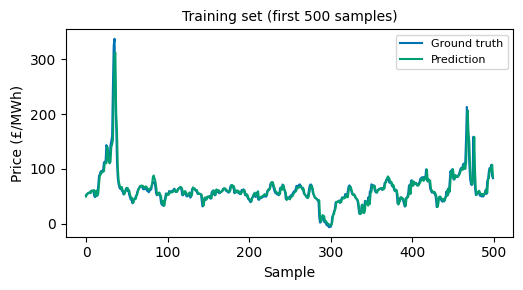

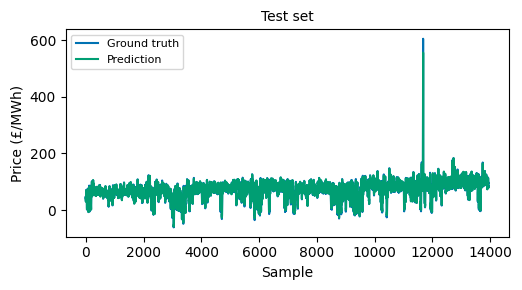

In [12]:
# Plot predictions
# Training set
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.plot(y_train[:500], label='Ground truth')
ax.plot(y_train_pred[:500], label='Prediction')
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
ax.set_title('Training set (first 500 samples)', fontsize=10)
ax.legend(fontsize=8)
plt.show()
# Test set
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.plot(y_test, label='Ground truth')
ax.plot(y_test_pred, label='Prediction')
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
ax.set_title(f'Test set', fontsize=10)
ax.legend(fontsize=8)
plt.show()

/var/folders/r2/fdwz5hy15238clh3yp9jsd5m0000gn/T/ipykernel_31732/3813619957.py:4: RuntimeWarning: divide by zero encountered in divide
  rel_errors_train = np.abs(errors_train) / np.abs(y_train)
/var/folders/r2/fdwz5hy15238clh3yp9jsd5m0000gn/T/ipykernel_31732/3813619957.py:5: RuntimeWarning: divide by zero encountered in divide
  rel_errors_test = np.abs(errors_test) / np.abs(y_test)


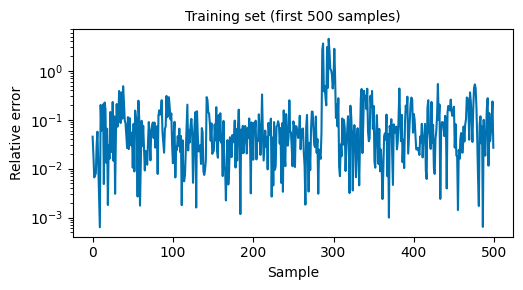

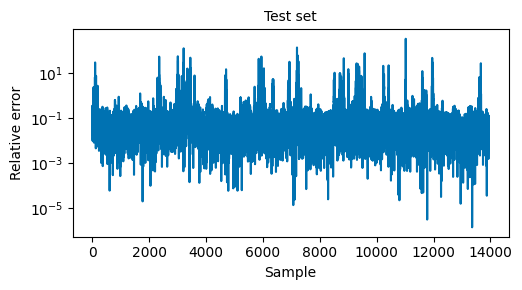

In [13]:
# Plot errors
errors_train = y_train_pred - y_train
errors_test = y_test_pred - y_test
rel_errors_train = np.abs(errors_train) / np.abs(y_train)
rel_errors_test = np.abs(errors_test) / np.abs(y_test)

fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.plot(rel_errors_train[:500])
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Relative error', fontsize=10)
ax.set_title('Training set (first 500 samples)', fontsize=10)
ax.set_yscale('log')

fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.plot(rel_errors_test)
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Relative error', fontsize=10)
ax.set_title('Test set', fontsize=10)
ax.set_yscale('log')
plt.show()

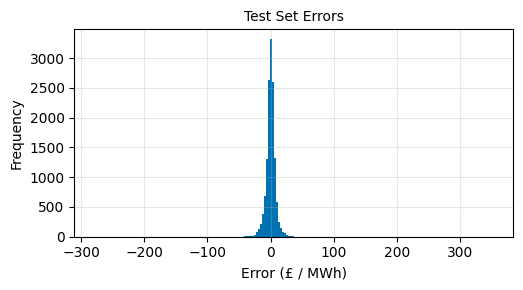

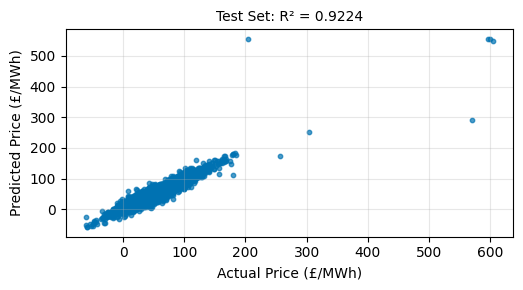

In [14]:
# Analyse errors
# histogram of errors
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.hist(errors_test, bins=200)
ax.set_xlabel('Error (£ / MWh)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_title(f'Test Set Errors', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()
# predicted vs actual prices
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.scatter(y_test, y_test_pred, alpha=0.7, s=10)
ax.set_xlabel('Actual Price (£/MWh)', fontsize=10)
ax.set_ylabel('Predicted Price (£/MWh)', fontsize=10)
ax.set_title(f'Test Set: R² = {test_metrics["r2"]:.4f}', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()